In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import glob
from pathlib import Path

from src.data_models.camels_ch import CamelsCH, CamelsCHConfig, get_all_gauge_ids
from src.data_models.dataset import HydroDataset
from src.data_models.preprocessing import (
    scale_time_series,
    scale_static_attributes,
    inverse_scale_static_attributes,
    inverse_scale_time_series,
)

from utils.metrics import nash_sutcliffe_efficiency
from src.data_models.datamodule import HydroDataModule

---

# 1. Load and prepare CAMELS-CH data

In [3]:
camels_config = CamelsCHConfig(
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/timeseries/observation_based/",
    timeseries_pattern="CAMELS_CH_obs_based_*.csv",
    static_attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/static_attributes",
    use_climate=False,
    use_geology=False,
    use_glacier=False,
    use_human_influence=False,
    use_hydrogeology=False,
    use_hydrology=False,
    use_landcover=False,
    use_soil=False,
    use_topographic=False,
)

In [4]:
all_gauge_ids = get_all_gauge_ids(camels_config)

ids_for_training = all_gauge_ids[10:60]

camels = CamelsCH(camels_config)
camels.load_stations(ids_for_training)

Loaded time series data for 50 stations


In [5]:
# static = camels.get_static_attributes()
# # q_mean	runoff_ratio	stream_elas	slope_fdc	baseflow_index_landson	hfd_mean
# static = static[["gauge_id", "q_mean", "runoff_ratio", "stream_elas", "slope_fdc", "baseflow_index_landson", "hfd_mean"]]
# static

## Get time series data


In [6]:
data = camels.get_time_series()
data = data[
    [
        "gauge_id",
        "date",
        "discharge_spec(mm/d)",
        "precipitation(mm/d)",
        "temperature_mean(degC)",
    ]
]

# # Split into train/test
# df_train, df_test = train_validate_split(data, train_ratio=0.8)

# # Scale by basin
# scaled_train, scaled_test, params = scale_time_series(
#     df_train,
#     df_test,
#     features=["discharge_spec(mm/d)", "precipitation(mm/d)", "temperature_mean(degC)"],
#     by_basin=True,  # Set False for global scaling
# )

In [7]:
# attributes = [col for col in static.columns if col != 'gauge_id']

# # Scale the attributes
# scaled_static_df, scaling_params = scale_static_attributes(static, attributes)

# # Add back gauge_id if needed
# scaled_static_df['gauge_id'] = static['gauge_id']

# # Inverse scale to verify
# original_df = inverse_scale_static_attributes(scaled_static_df[attributes], scaling_params)
# original_df['gauge_id'] = static['gauge_id']

# # Print results
# print("\nOriginal values:")
# print(static)
# print("\nScaled values:")
# print(scaled_static_df)
# print("\nInverse scaled values:")
# print(original_df)

# # Verify the scaling worked correctly
# np.testing.assert_array_almost_equal(
#     static[attributes].values,
#     original_df[attributes].values
# )
# print("\nVerification passed: Original and inverse-scaled values match!")

# 2. Configure preprocessing

In [8]:
preprocessing_config = {
    "features": {
        "scale_method": "per_basin",
        "log_transform": []
    },
    "target": {
        "scale_method": "per_basin",
        "log_transform": False
    },
    "static_features": {
        "scale_method": "global"
    }
}

# 3. Create DataModule

In [9]:
data_module = HydroDataModule(
    time_series_df=data,
    static_df=None,
    preprocessing_config=preprocessing_config,
    batch_size=32,
    input_length=30,
    output_length=1,
    num_workers=4,
    features=["discharge_spec(mm/d)", "precipitation(mm/d)", "temperature_mean(degC)"],
    target="discharge_spec(mm/d)",
    train_years=10,
    val_years=1,
    min_test_years=1,
)

## Wrap the data in a PyTorch dataset

In [10]:
# features = ["discharge_spec(mm/d)", "precipitation(mm/d)", "temperature_mean(degC)"]
# target = "discharge_spec(mm/d)"

# # Create dataset
# train_dataset = HydroDataset(
#     time_series_df=scaled_train,
#     static_df=None,
#     input_length=30,
#     output_length=5,
#     features=features,
#     target=target,
# )

# validate_dataset = HydroDataset(
#     time_series_df=scaled_train,
#     static_df=None,
#     input_length=30,
#     output_length=5,
#     features=features,
#     target=target,
# )

## Make the dataset iterable by creating a DataLoader

In [11]:
# batch_size = 32

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

## 4. Create model and train

In [12]:
from src.models.lstm import LitLSTM
from torch.optim import Adam
from torch.nn import MSELoss

In [13]:
model = LitLSTM(
    input_size=3,
    hidden_size=64,
    num_layers=1,
    output_size=1,
    target="discharge_spec(mm/d)",
)


# Configure trainer
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints",
            filename="best-checkpoint",
            save_top_k=1,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    ],
) 

# Train the model
trainer.fit(model, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default



Quality Check Summary:
Original basins: 50
Retained basins: 16
Excluded basins: 26


/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/cooper/Desktop/CAMELS-CH/notebooks/checkpoints exists and is not empty.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | SimpleLSTM | 17.7 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Data preprocessing completed with temporal splitting:
- Using first 10 years of each basin for fitting scalers
- Features scaled using per_basin method
- Target scaled using per_basin method
- Log transforms applied to: [] and target: False
Created 57952 valid sequences.
Created 5360 valid sequences.

Data split summary:
Training: 58432 samples from 16 basins
Validation: 5840 samples from 16 basins
Testing: 169488 samples from 16 basins
Epoch 4: 100%|██████████| 1811/1811 [00:15<00:00, 117.45it/s, v_num=19]     

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1811/1811 [00:15<00:00, 117.43it/s, v_num=19]


# 5. Evalue and plot results

In [14]:
quality_report = data_module.quality_report

excluded_basins = list(quality_report["excluded_basins"].keys())
excluded_basins

ids_for_training = all_gauge_ids[10:60]
ids_for_training = [id for id in ids_for_training if id not in excluded_basins]

In [15]:
excluded_basins

['2066',
 '2072',
 '2073',
 '2088',
 '2113',
 '2116',
 '2462',
 '2500',
 '3019',
 '3022',
 '3025',
 '3026',
 '3027',
 '3031',
 '4003',
 '4006',
 '4007',
 '4010',
 '4012',
 '4013',
 '4017',
 '6001',
 '6002',
 '6003',
 '6006',
 '6007']

In [25]:
trainer.test(model, data_module)
test_results = model.test_results

# Get predictions and transform
df_pred = pd.DataFrame(test_results["predictions"], columns=[model.hparams.target])
df_pred["gauge_id"] = test_results["basin_ids"]
df_targets = pd.DataFrame(test_results["targets"], columns=[model.hparams.target])
df_targets["gauge_id"] = test_results["basin_ids"]


Quality Check Summary:
Original basins: 50
Retained basins: 16
Excluded basins: 26
Data preprocessing completed with temporal splitting:
- Using first 10 years of each basin for fitting scalers
- Features scaled using per_basin method
- Target scaled using per_basin method
- Log transforms applied to: [] and target: False
Created 169008 valid sequences.

Data split summary:
Training: 58432 samples from 16 basins
Validation: 5840 samples from 16 basins
Testing: 169488 samples from 16 basins
Testing DataLoader 0: 100%|██████████| 5282/5282 [00:16<00:00, 325.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.18839587271213531
───────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
# Option 2: Filter within a test DataLoader batch
test_loader = data_module.test_dataloader()
for batch in test_loader:
    # Assuming batch["gauge_id"] is a list of strings
    mask = [g == "2070" for g in batch["gauge_id"]]
    if any(mask):
        # Convert mask to indices for tensor slicing if necessary
        x_b2070 = batch["X"][mask]
        y_b2070 = batch["y"][mask]
        print("Basin 2070 X:", x_b2070)
        print("Basin 2070 y:", y_b2070)


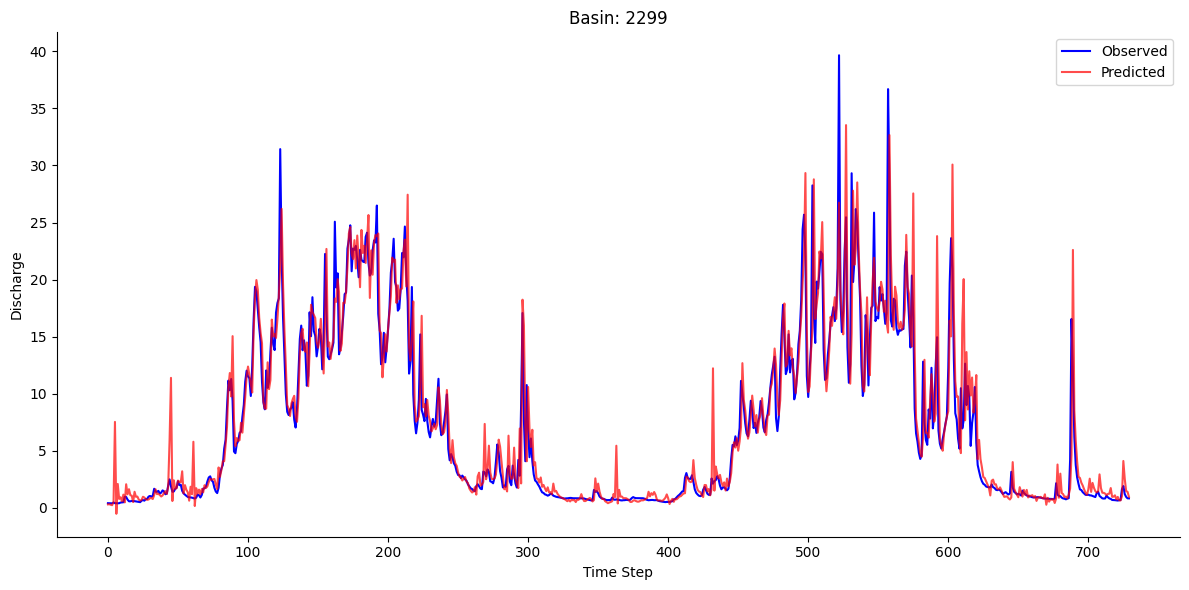

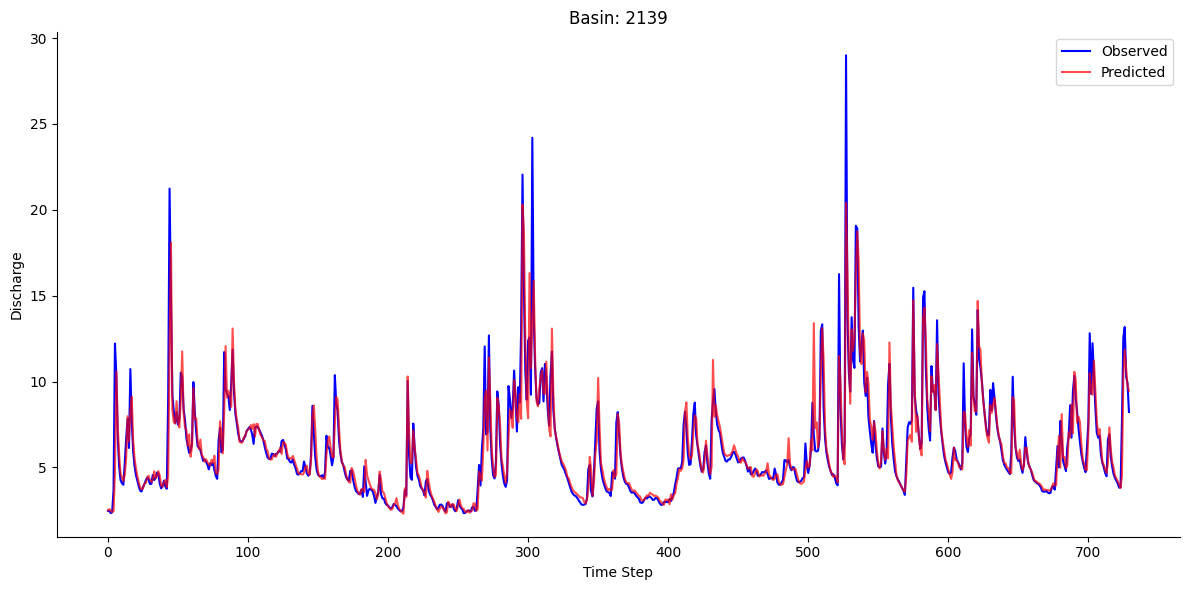

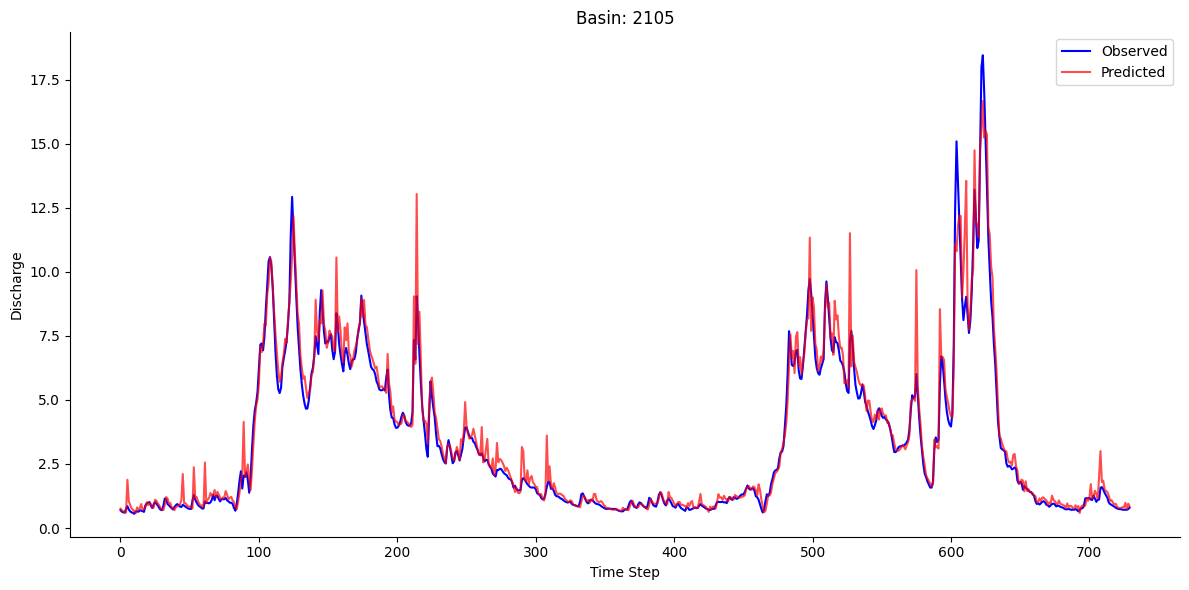

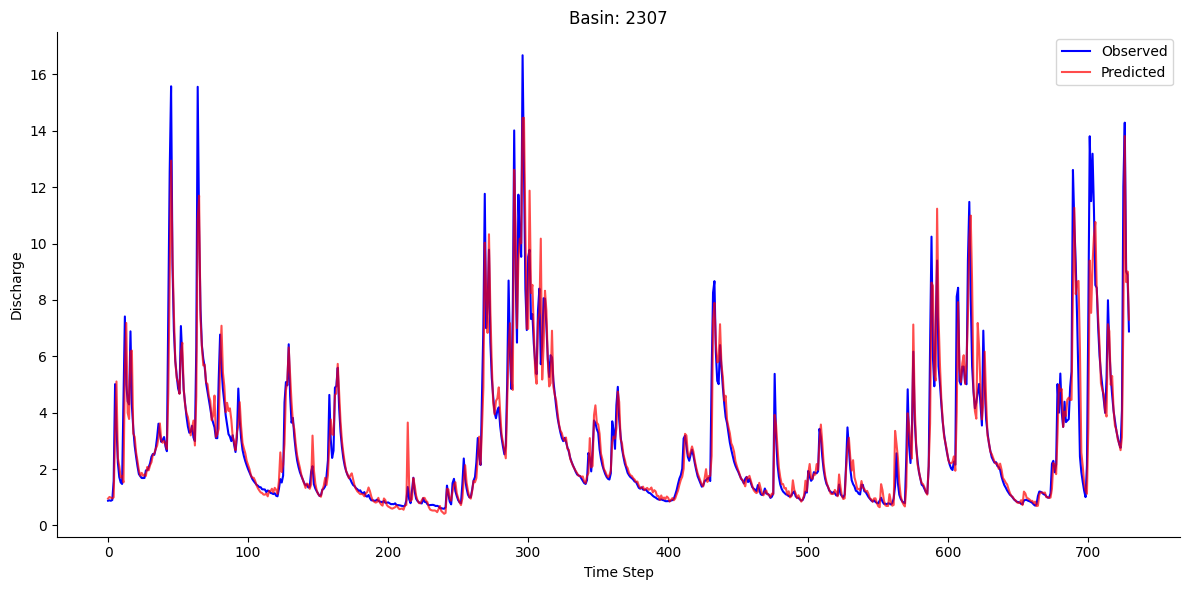

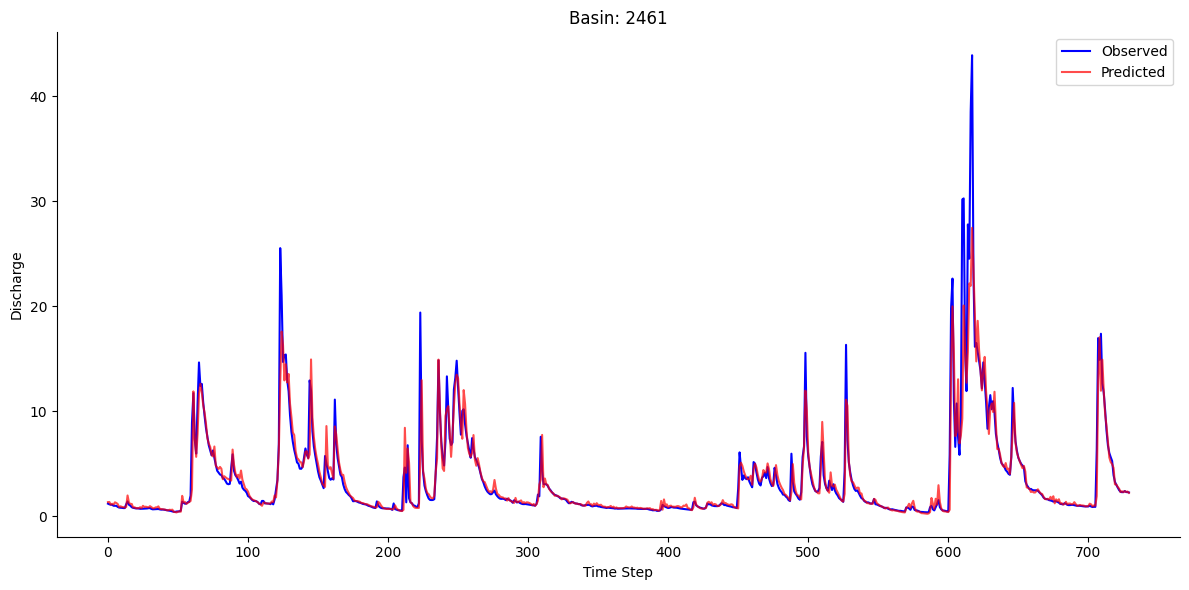

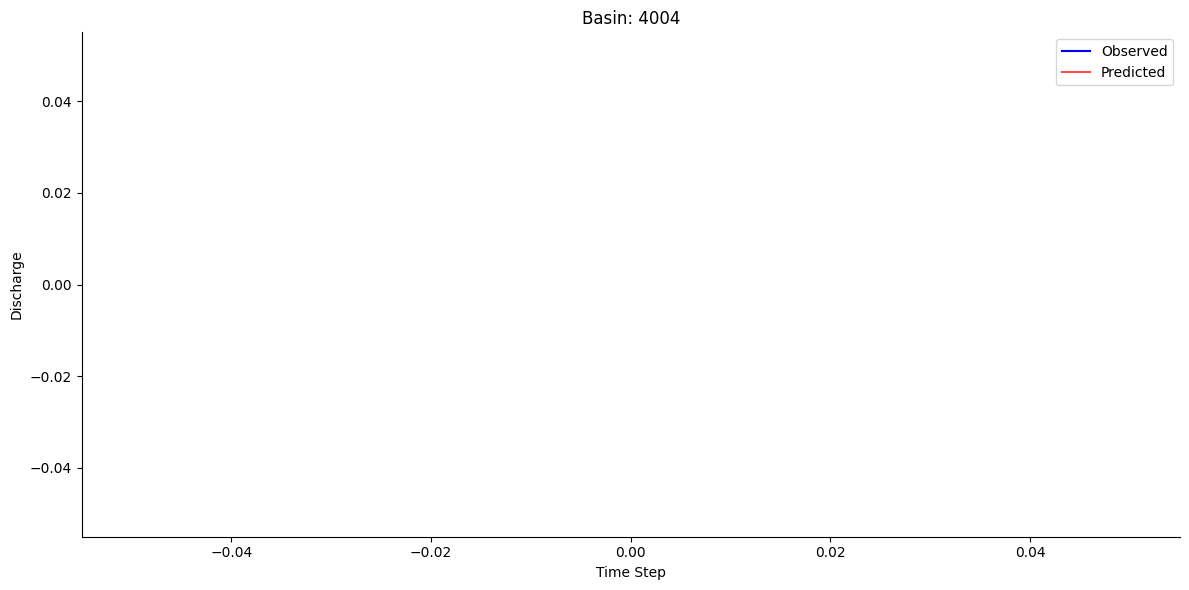

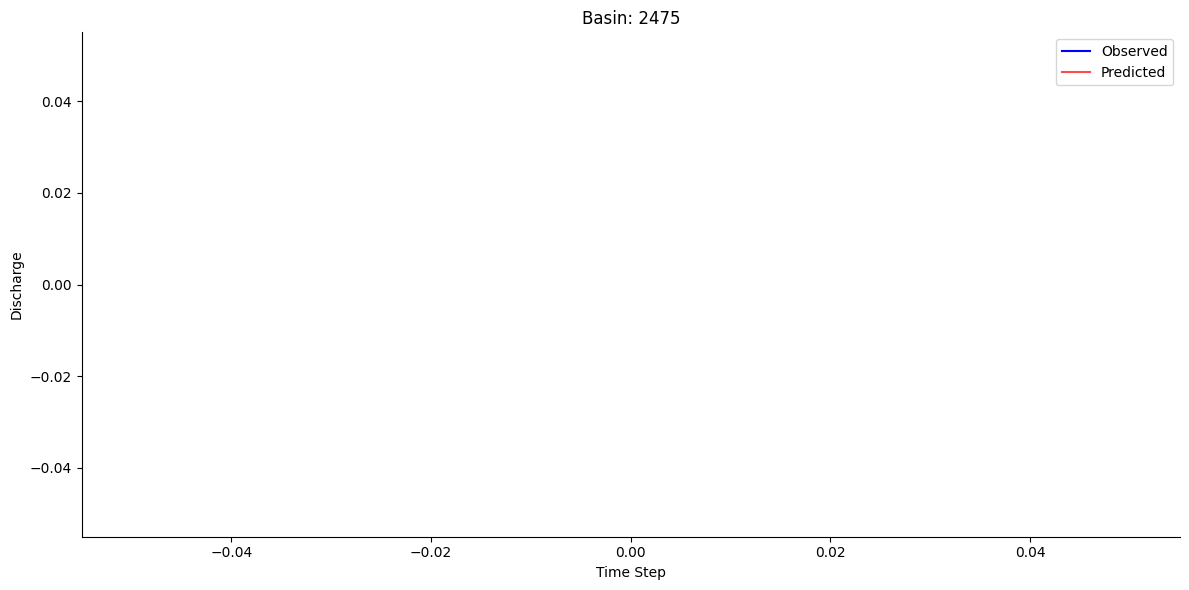

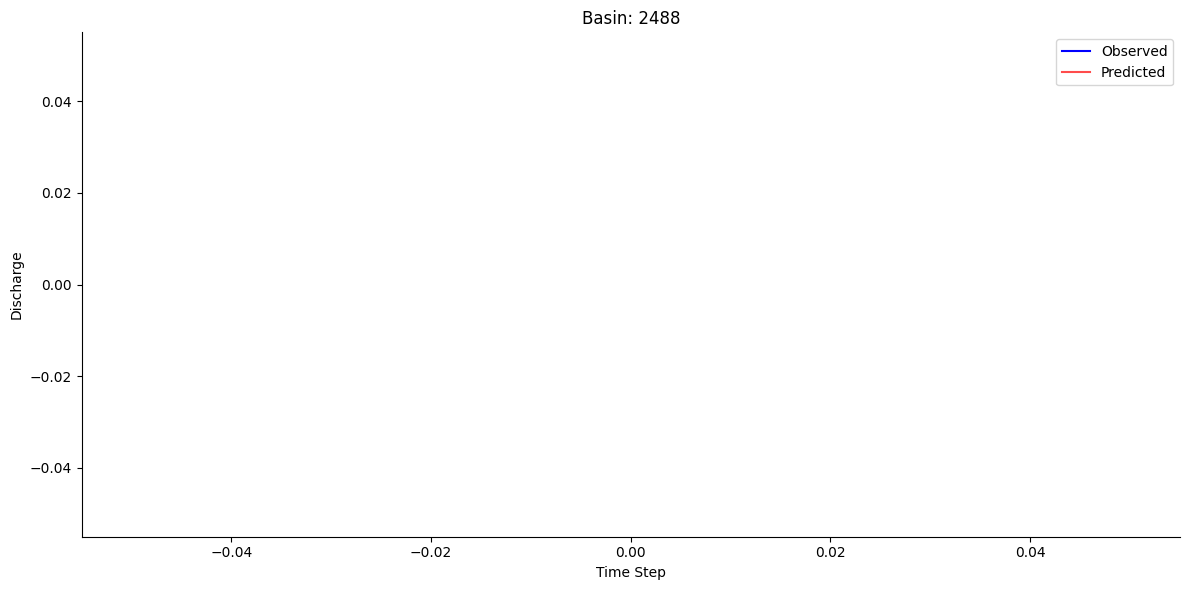

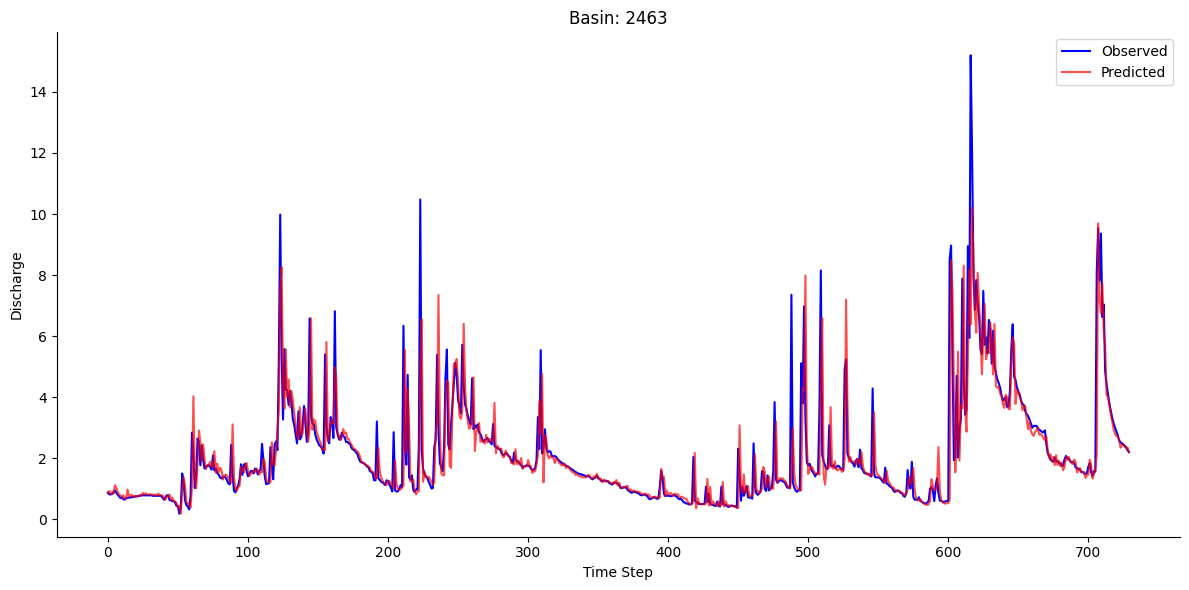

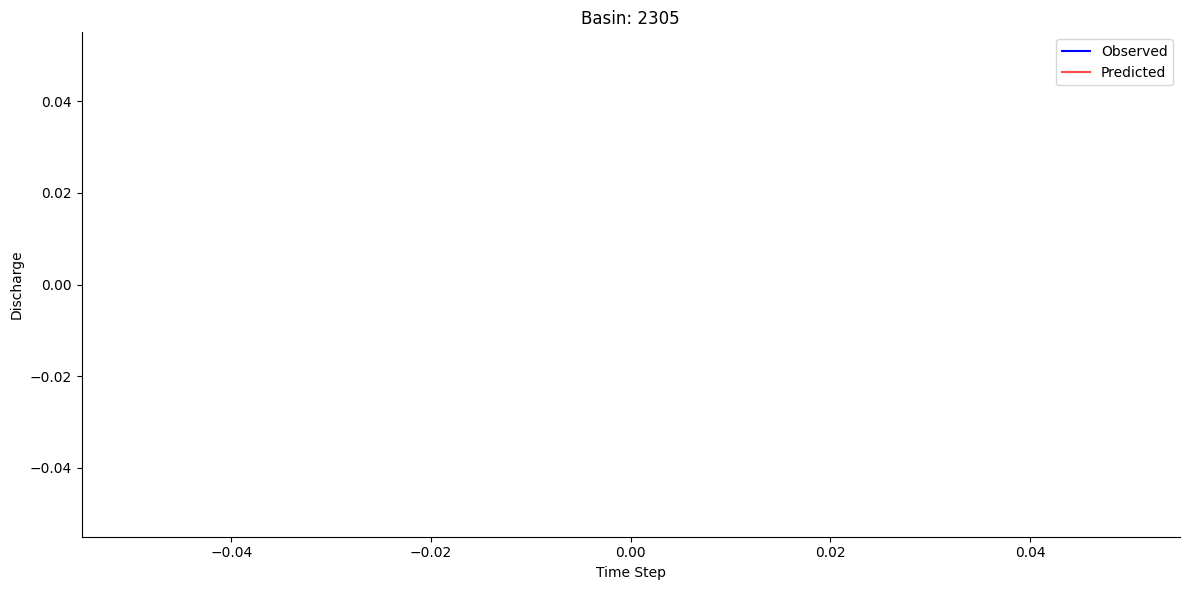

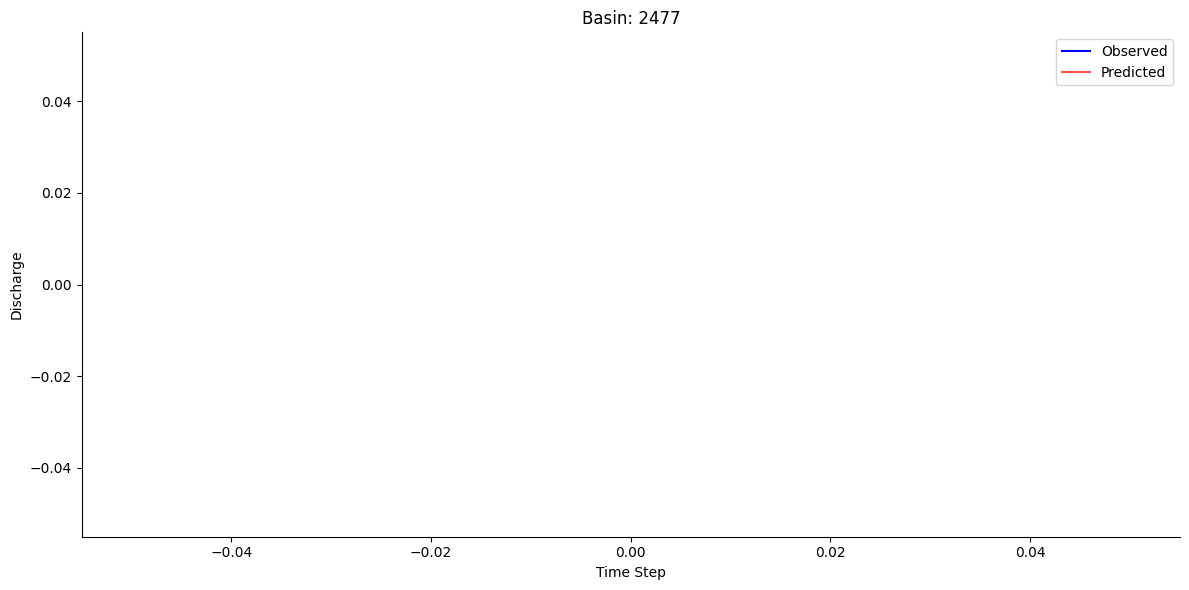

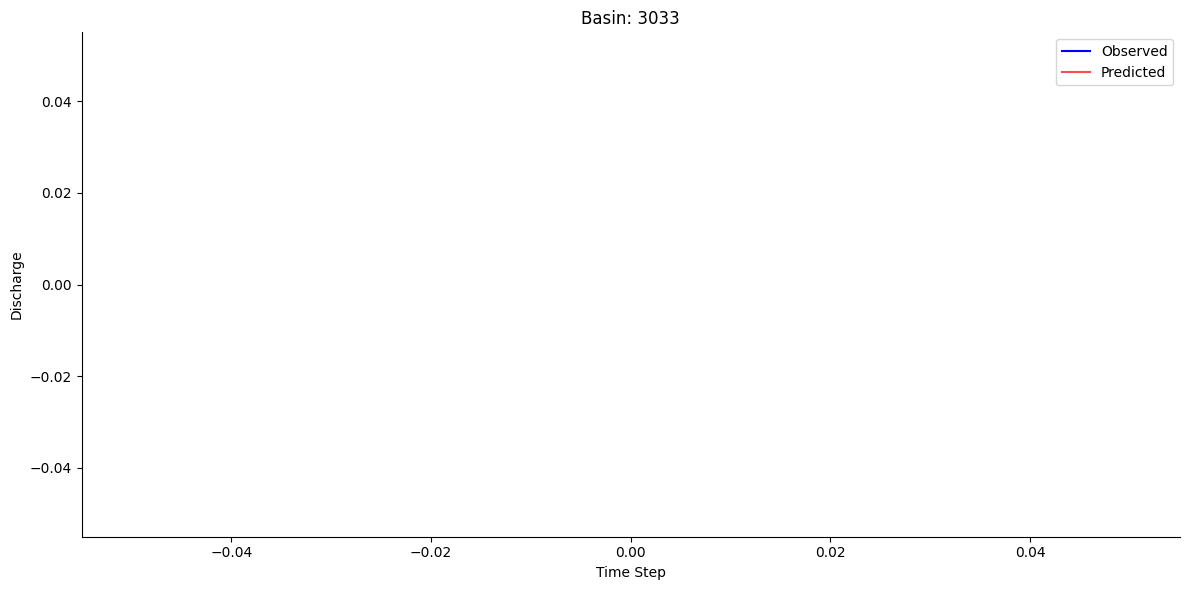

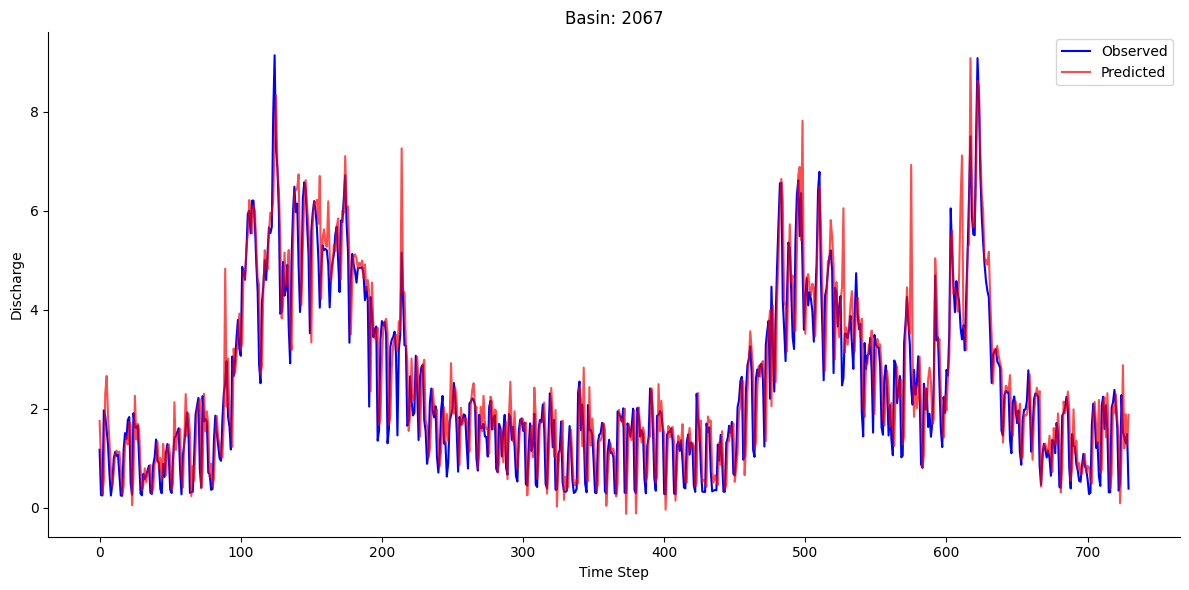

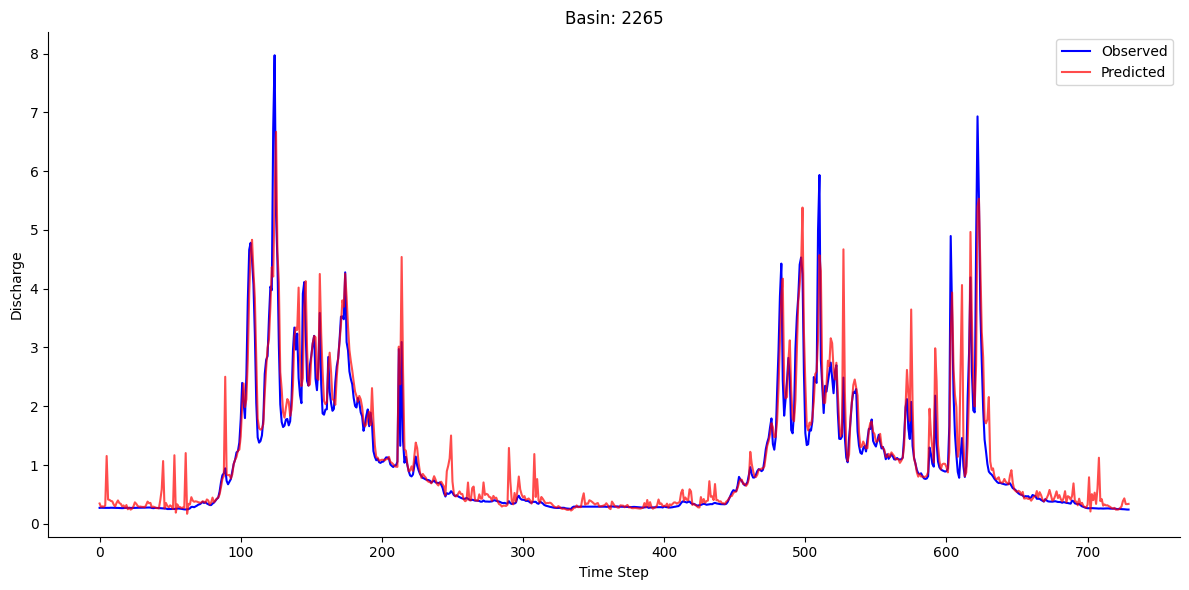

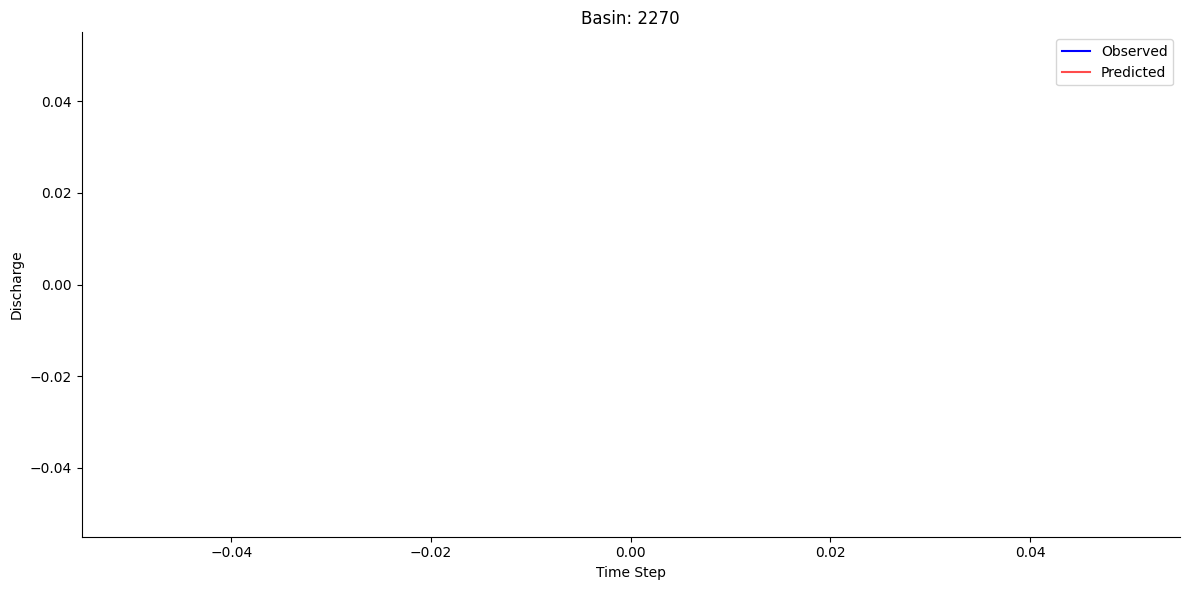

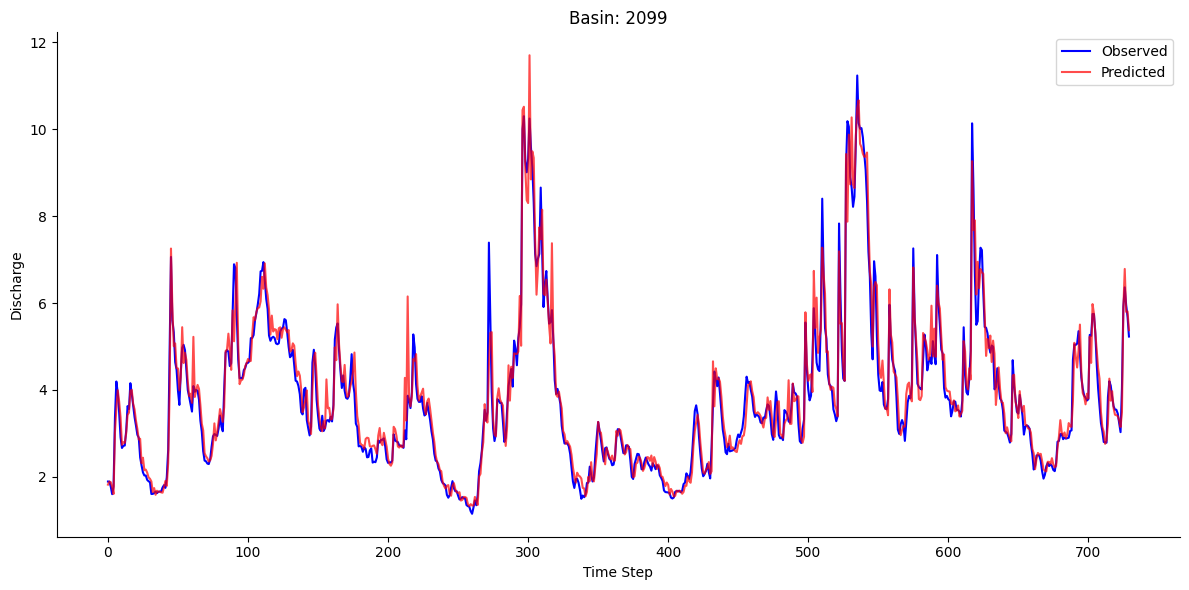

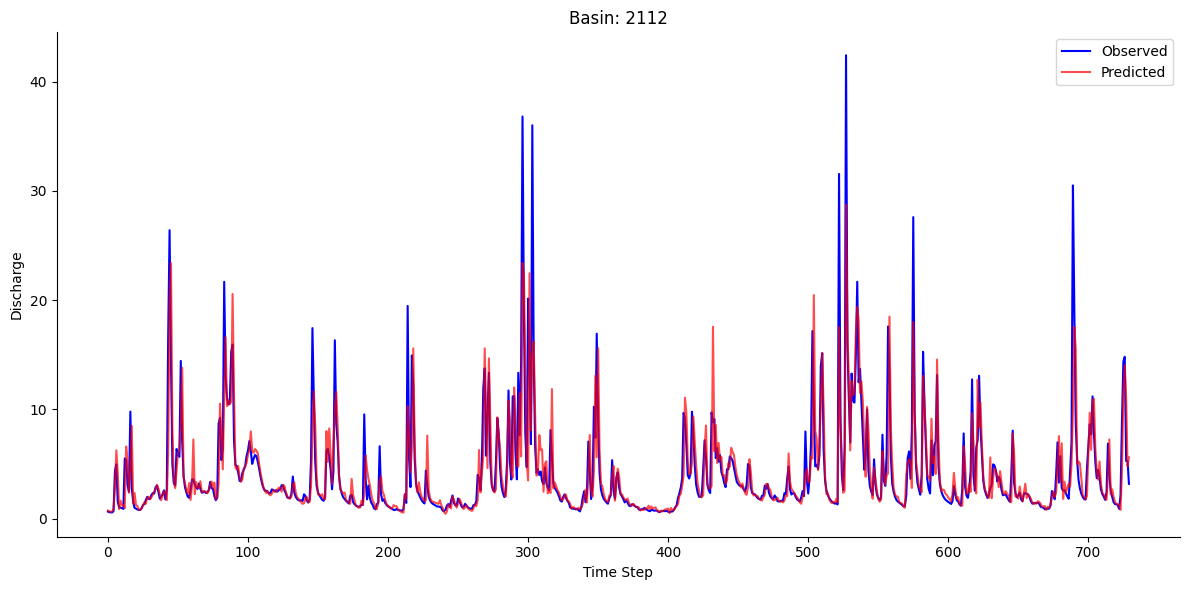

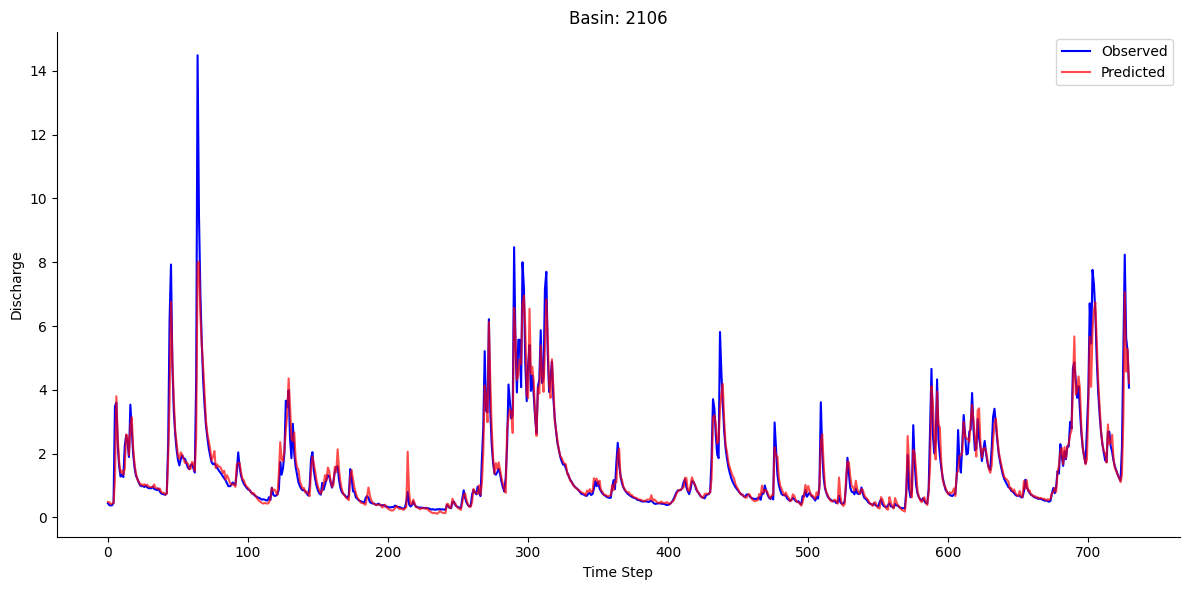

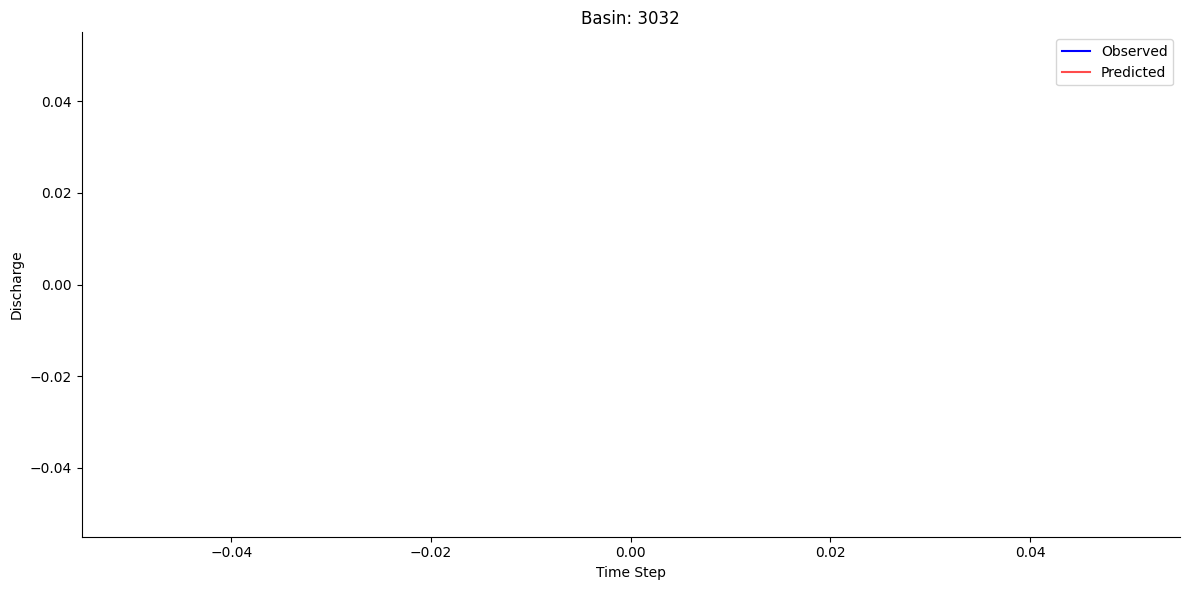

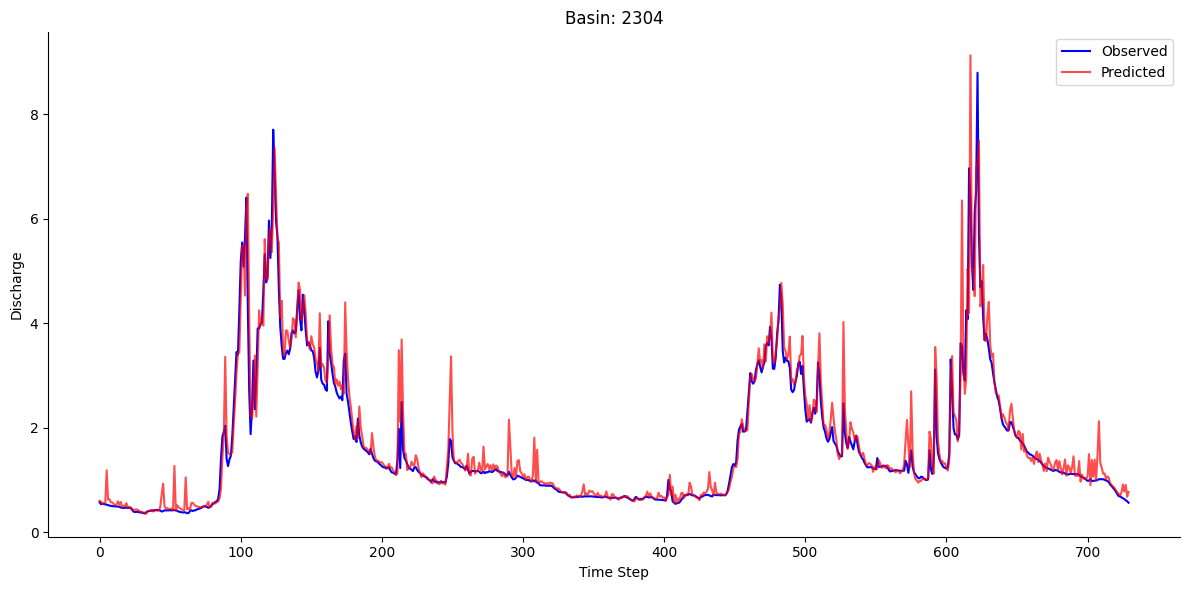

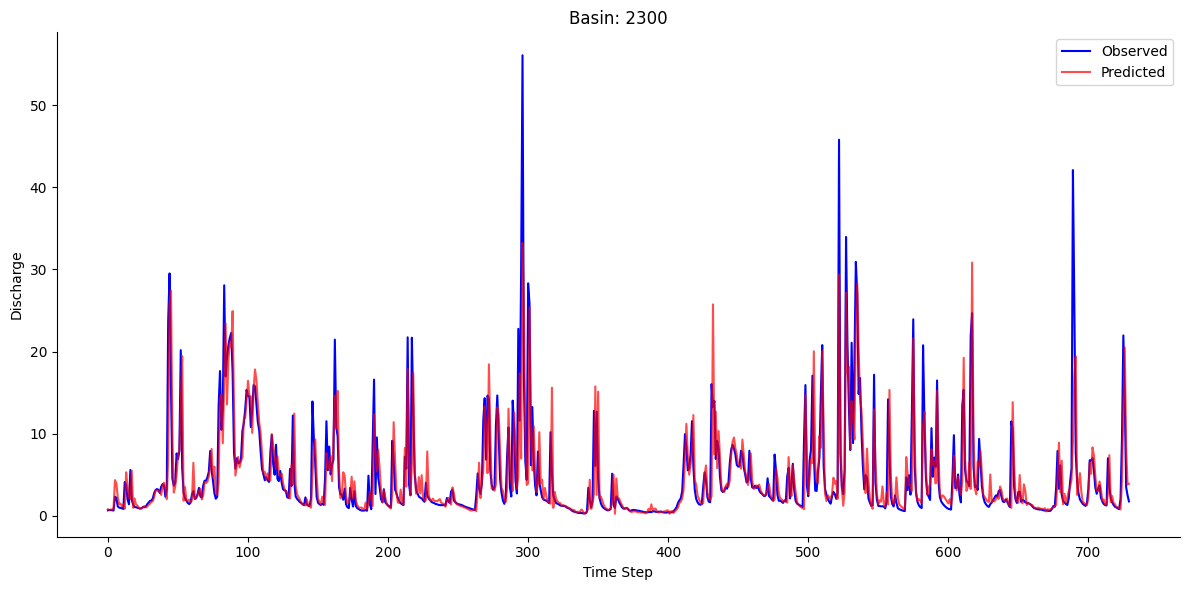

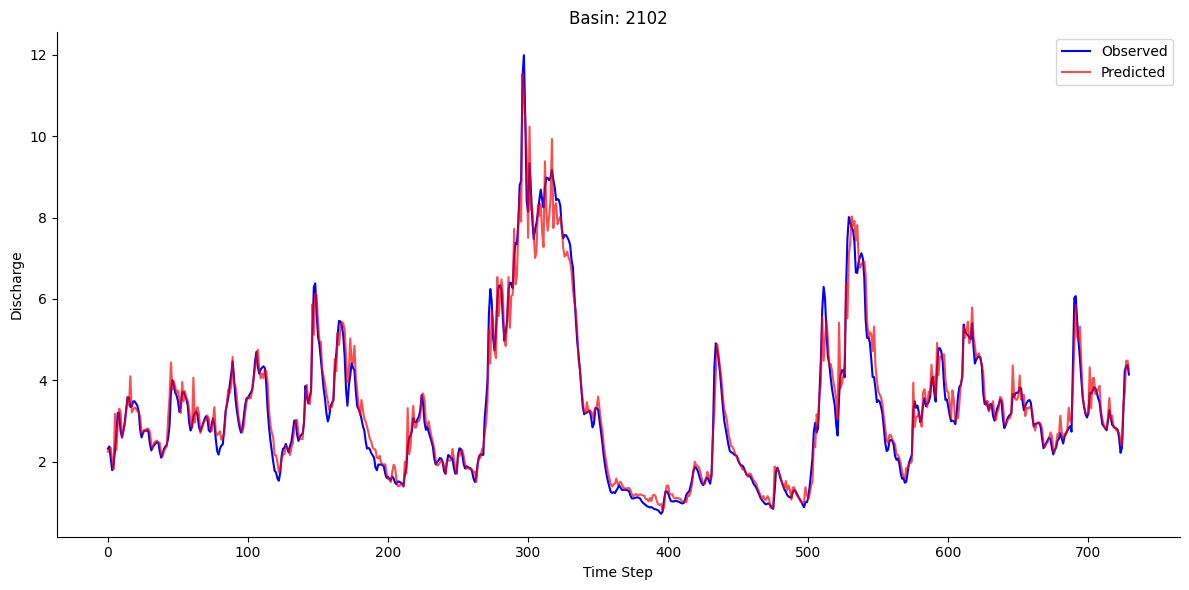

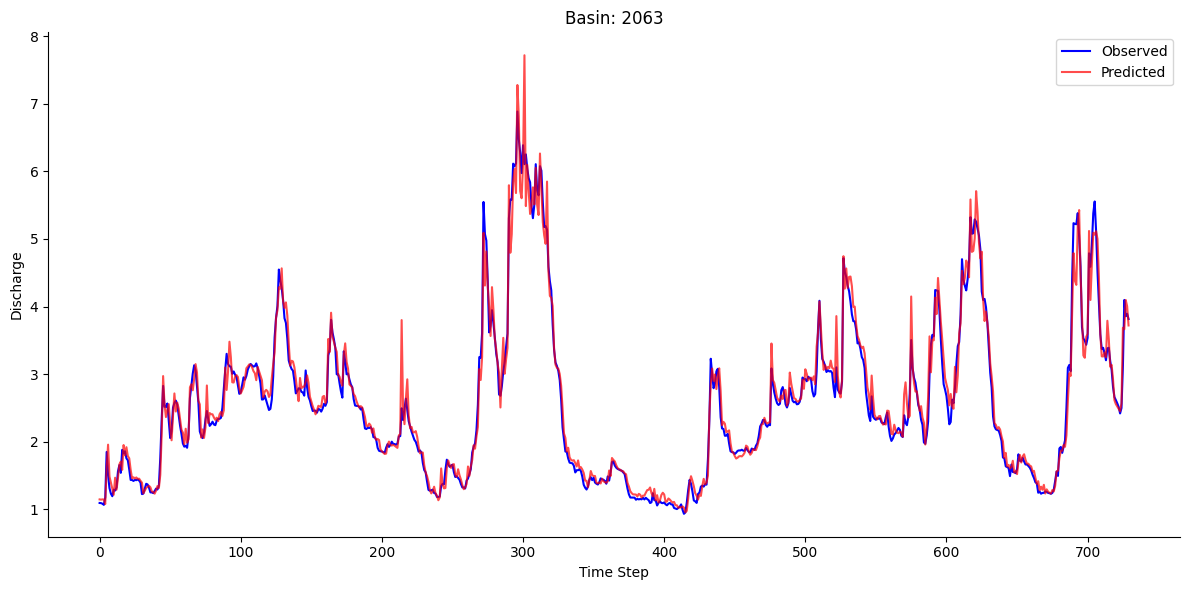

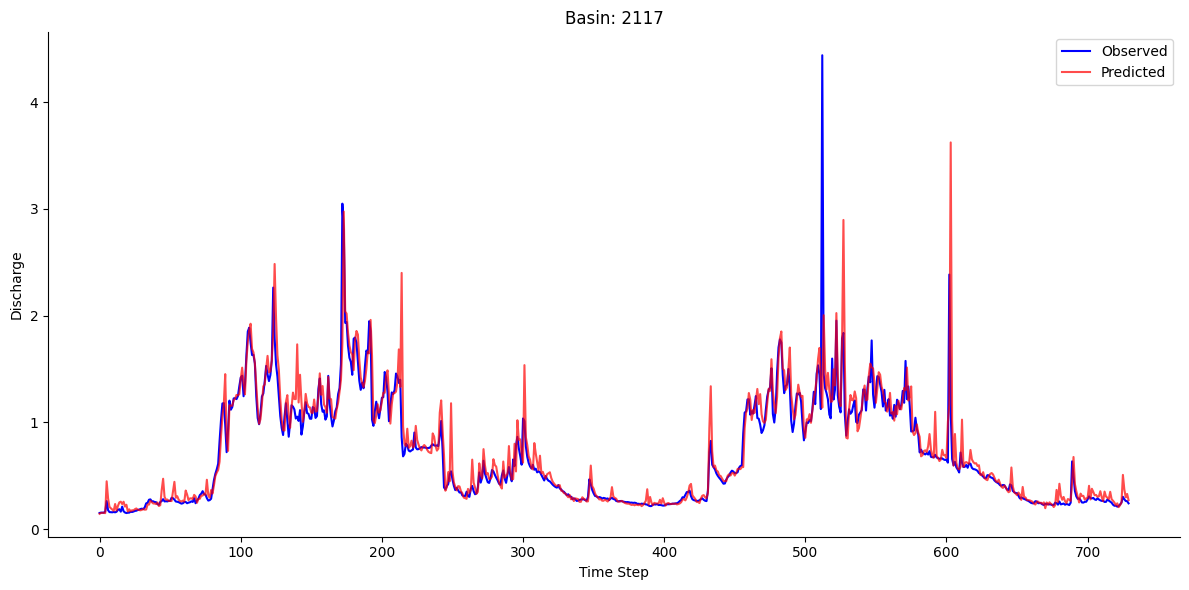

In [24]:
def plot_basin_time_series(
    predictions: np.ndarray,
    targets: np.ndarray,
    basin_ids: np.ndarray,
    basin_to_plot: str,
):
    """Plot time series predictions for a specific basin."""
    mask = basin_ids == basin_to_plot

    plt.figure(figsize=(12, 6))
    plt.plot(targets[mask], label="Observed", alpha=1, color="blue")
    plt.plot(predictions[mask], label="Predicted", alpha=0.7, color="red")
    plt.title(f"Basin: {basin_to_plot}")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Discharge")
    plt.tight_layout()
    sns.despine()

    plt.show()


predictions = data_module.inverse_transform_predictions(
    test_results["predictions"], test_results["basin_ids"]
)
targets = data_module.inverse_transform_predictions(
    test_results["targets"], test_results["basin_ids"]
)

for gauge_id in ids_for_training:
    mask = test_results["basin_ids"] == gauge_id
    # Use mask to plot only that basin's data (taking first 365*2 points if needed)
    plot_basin_time_series(
        predictions[mask][: 365 * 2],
        targets[mask][: 365 * 2],
        test_results["basin_ids"][mask][: 365 * 2],
        gauge_id,
    )

    # NSE = nash_sutcliffe_efficiency(observed=targets[mask], simulated=predictions[mask])
    # print(f"Basin {gauge_id} NSE: {NSE:.3f}")

In [23]:
test_results["predictions"]

array([[-1.2239274 ],
       [-1.2265524 ],
       [-1.2236224 ],
       ...,
       [ 0.5286355 ],
       [ 0.4928804 ],
       [ 0.31898624]], shape=(169008, 1), dtype=float32)

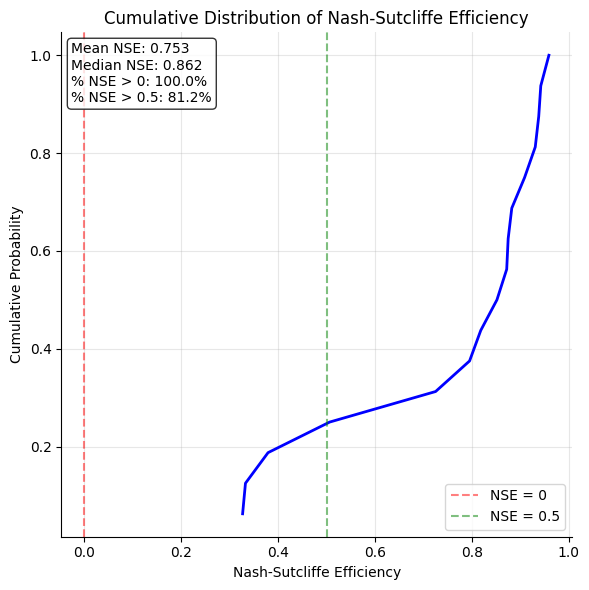

In [18]:
from typing import Dict

def calculate_basin_nses(
    predictions: np.ndarray,
    targets: np.ndarray,
    basin_ids: np.ndarray
) -> Dict[str, float]:
    """Calculate NSE for each basin"""
    unique_basins = np.unique(basin_ids)
    nse_values = {}
    
    for basin in unique_basins:
        mask = basin_ids == basin
        nse = nash_sutcliffe_efficiency(targets[mask], predictions[mask])
        nse_values[basin] = nse
        
    return nse_values

def plot_nse_cdf(
    nse_values: Dict[str, float],
    title: str = "Cumulative Distribution of Nash-Sutcliffe Efficiency",
    figsize: tuple = (6, 6)
) -> None:
    """
    Plot the cumulative distribution function of NSE values.
    
    Args:
        nse_values: Dictionary mapping basin IDs to their NSE values
        title: Plot title
        figsize: Figure size as (width, height)
    """
    # Convert NSE values to array and sort
    nse_array = np.array(list(nse_values.values()))
    nse_array = np.sort(nse_array)
    
    # Calculate cumulative probabilities
    p = np.arange(1, len(nse_array) + 1) / len(nse_array)
    
    # Create plot
    plt.figure(figsize=figsize)
    plt.plot(nse_array, p, 'b-', linewidth=2)
    
    # Add reference lines
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='NSE = 0')
    plt.axvline(x=0.5, color='g', linestyle='--', alpha=0.5, label='NSE = 0.5')
    
    # Customize plot
    plt.grid(True, alpha=0.3)
    plt.xlabel('Nash-Sutcliffe Efficiency')
    plt.ylabel('Cumulative Probability')
    plt.title(title)
    plt.legend()
    
    # Add summary statistics
    stats_text = (
        f'Mean NSE: {np.mean(nse_array):.3f}\n'
        f'Median NSE: {np.median(nse_array):.3f}\n'
        f'% NSE > 0: {(nse_array > 0).mean()*100:.1f}%\n'
        f'% NSE > 0.5: {(nse_array > 0.5).mean()*100:.1f}%'
    )
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    sns.despine()
    plt.tight_layout()
    plt.show()

nse_values = calculate_basin_nses(targets, predictions, test_results["basin_ids"])
plot_nse_cdf(nse_values)